In [1]:
from collections import defaultdict, Counter
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats

In [10]:
chrom = '22'
ihart_family_sizes = [3, 4, 5, 6, 7]
ihart_phase_dir = '../phased_ihart'
ihart_data_dir = '../split_gen_ihart'

ssc_family_sizes = [4]
ssc_phase_dir = '../phased_ssc'

In [3]:
ped_files = ['../data/160826.ped', '../data/ssc.ped']
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
fam_to_inds = dict()

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                famkey = '.'.join((fam_id, m_id, f_id))
                if famkey not in fam_to_inds:
                    fam_to_inds[famkey] = [m_id, f_id]
                fam_to_inds[famkey].append(child_id)
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

In [4]:
# From GRCh37.p13 https://www.ncbi.nlm.nih.gov/grc/human/data?asm=GRCh37.p13
chrom_lengths = {
	'1': 249250621,
	'2': 243199373,
	'3': 198022430,
	'4': 191154276,
	'5': 180915260,
	'6': 171115067,
	'7': 159138663,
	'8': 146364022,
	'9': 141213431,
	'10': 135534747,
	'11': 135006516,
	'12': 133851895,
	'13': 115169878,
	'14': 107349540,
	'15': 102531392,
	'16': 90354753,
	'17': 81195210,
	'18': 78077248,
	'19': 59128983,
	'20': 63025520,
	'21': 48129895,
	'22': 51304566,
	'X': 155270560,
	'Y': 59373566
}

# Filter Families


In [6]:
family_to_individuals = dict()

for j in ihart_family_sizes:
    try:
        with open('%s/chr.%s.familysize.%d.families.txt' % (ihart_phase_dir, chrom, j), 'r') as f:
            next(f) # skip header
            for line in f:
                pieces = line.strip().split('\t')
                family_key = pieces[0]
                family_to_individuals[family_key] = pieces[1:(1+j)]
    except FileNotFoundError:
        print('File not found', 'chrom', chrom, 'family size', j)
    except StopIteration:
        print('File empty', 'chrom', chrom, 'family size', j)

In [9]:
ihart_individuals = sorted(sum(family_to_individuals.values(), []))
ihart_ind_to_index = dict([(x, i) for i, x in enumerate(ihart_individuals)])
print('individuals', len(ihart_individuals))

individuals 3994


# Pull genotype data

In [12]:

# pull families with sequence data
sample_file = '%s/chr.%s.gen.samples.txt' % (ihart_data_dir, chrom)
with open(sample_file, 'r') as f:
    sample_ids = [line.strip() for line in f]
sample_id_to_index = dict([(sample_id, i) for i, sample_id in enumerate(sample_ids)])

# use only "cleaned" variants - must be SNPs
coordinates = np.load('%s/chr.%s.gen.coordinates.npy' % (ihart_data_dir,  chrom))
snp_positions = coordinates[:, 1]
snp_indices = coordinates[:, 2]==1
snp_positions = snp_positions[snp_indices]

from scipy import sparse
from os import listdir

# pull genotype data from .npz
gen_files = sorted([f for f in listdir(ihart_data_dir) if ('chr.%s' % chrom) in f and 'gen.npz' in f])
whole_chrom = sparse.hstack([sparse.load_npz('%s/%s' % (ihart_data_dir, gen_file)) for gen_file in gen_files])
whole_chrom = whole_chrom[:, snp_indices]

total_inds, n = whole_chrom.shape
print('chrom shape', total_inds, n)

chrom shape 4610 1004649


In [13]:
whole_chrom[whole_chrom < 0] = -1

# Read in deletions


In [54]:
# -1: unknown
# 0: no deletions (homref)
# 1: het deletion
# 2: homalt deletion
# 3: either 0 or 1
# 4: either 1 or 2
gen_to_code = {(-1, -1): 5,
                   (-1, 0): 4,
                   (-1, 1): 3,
                   (0, -1): 4,
                   (0, 0): 2,
                   (0, 1): 1,
                   (1, -1): 3,
                   (1, 0): 1,
                   (1, 1): 0
                  }

In [99]:

gen_counts = np.zeros((snp_positions.shape[0], 4, 3), dtype=int)
people_counts = np.zeros((snp_positions.shape[0], 3), dtype=int)
for j in ihart_family_sizes:
    print(j)
    with open('%s/chr.%s.familysize.%d.phased.txt' % (ihart_phase_dir, chrom, j), 'r')  as f:
        next(f) # skip header

        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            inds = family_to_individuals[family_key]
            gen_indices = [sample_id_to_index[x] for x in inds]
            state = np.array([int(x) for x in pieces[1:(2+(j*2))]])
            start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]
            
            if state[-1]==0:
                
                # mom
                if np.all(state[:2]==0):
                    pass
                else:
                    if not np.any(state[range(4, len(state)-1, 2)]==0):
                        state[0] = -1
                    if not np.any(state[range(4, len(state)-1, 2)]==1):
                        state[1] = -1

                delgen = gen_to_code[(state[0], state[1])]
                if delgen >= 0 and delgen <= 2:
                    pos_indices = np.where((snp_positions >= start_pos) & (snp_positions <= end_pos) & has_del)[0]
                    section = whole_chrom[gen_indices[0], pos_indices]
                    _, js = section.nonzero()
                    vs = section.data
                    gen_counts[pos_indices[js], vs, delgen] += 1
                    people_counts[pos_indices, delgen] += 1

                # dad
                if np.all(state[2:4]==0):
                    pass
                else:
                    if not np.any(state[range(5, len(state)-1, 2)]==0):
                        state[2] = -1
                    if not np.any(state[range(5, len(state)-1, 2)]==1):
                        state[3] = -1

                delgen = gen_to_code[(state[2], state[3])]
                if delgen >= 0 and delgen <= 2:
                    pos_indices = np.where((snp_positions >= start_pos) & (snp_positions <= end_pos) & has_del)[0]
                    section = whole_chrom[gen_indices[1], pos_indices]
                    _, js = section.nonzero()
                    vs = section.data
                    gen_counts[pos_indices[js], vs, delgen] += 1
                    people_counts[pos_indices, delgen] += 1

                ## children
                #for k in range(2, j):
                #    mom_s, dad_s = state[(2*k):(2*(k+1))]
                #    mom_gen, dad_gen = -1, -1
                #    if mom_s != -1:
                #        mom_gen = state[mom_s]
                #    if dad_s != -1:
                #        dad_gen = state[2+dad_s]
                #
                #    delgen = gen_to_code[(mom_gen, dad_gen)]
                #    if delgen >= 0 and delgen <= 2:
                #        _, js = whole_chrom[gen_indices[k], pos_indices].nonzero()
                #        vs = whole_chrom[gen_indices[k], pos_indices].data
                #        gen_counts[pos_indices[js], vs, delgen] += 1
                #        people_counts[pos_indices, delgen] += 1

3
4
5
6
7


# Can we use this information to handle unknown deletion status?

In [118]:
from collections import namedtuple
UnknownRegion = namedtuple('UnknownRegion', ['sample_id', 'start_pos', 'end_pos', 'length', 'delstatus'])

def pull_unknown_regions(family_key):
    inds = family_to_individuals[family_key]
    j = len(inds)
    unknown_regions = []
    with open('%s/chr.%s.familysize.%d.phased.txt' % (ihart_phase_dir, chrom, j), 'r')  as f:
        next(f) # skip header

        for line in f:
            pieces = line.strip().split('\t')
            if pieces[0] == family_key:

                gen_indices = [sample_id_to_index[x] for x in inds]
                state = np.array([int(x) for x in pieces[1:(2+(j*2))]])
                start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]

                if state[-1]==0:
                    # mom
                    if np.all(state[:2]==0):
                        pass
                    else:
                        if not np.any(state[range(4, len(state)-1, 2)]==0):
                            state[0] = -1
                        if not np.any(state[range(4, len(state)-1, 2)]==1):
                            state[1] = -1

                        delgen = gen_to_code[(state[0], state[1])]
                        if delgen in {-1, 3, 4}:
                            unknown_regions.append(UnknownRegion(inds[0], start_pos, end_pos, end_pos-start_pos+1, delgen))

                        # dad
                        if np.all(state[2:4]==0):
                            pass
                        else:
                            if not np.any(state[range(5, len(state)-1, 2)]==0):
                                state[2] = -1
                            if not np.any(state[range(5, len(state)-1, 2)]==1):
                                state[3] = -1

                        delgen = gen_to_code[(state[2], state[3])]
                        if delgen in {-1, 3, 4}:
                            unknown_regions.append(UnknownRegion(inds[1], start_pos, end_pos, end_pos-start_pos+1, delgen))
    return unknown_regions


In [238]:
import random

p = 24332998+(24406719-24332998)/2
region = None

while region is None:
    famkey, inds = random.choice(list(family_to_individuals.items()))
    print(famkey, len(inds))
    
    unknown_regions = pull_unknown_regions(famkey)
    rs = [x for x in unknown_regions if x.start_pos <= p and x.end_pos >= p]
    if len(rs) > 0:
        region = rs[0]

    
start_pos, end_pos = region.start_pos, region.end_pos
print(region.length)

AU1143.AU1143202.AU1143201 5
AU1691.AU1691202.AU1691201 5
AU1574.AU1574202.AU1574201 5
AU1548.AU1548202.AU1548201 4
AU1821.AU1821202.AU1821201 4
AU1789.AU1789202.AU1789201 5
AU1612.AU1612202.AU1612201 4
AU0885.AU0885202.AU0885201 6
AU0923.AU0923202.AU0923201 4
AU1832.AU1832202.AU1832201 4
28585


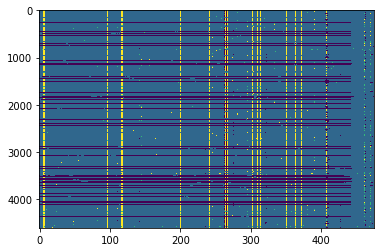

In [239]:
indices = (snp_positions >= start_pos) & (snp_positions <= end_pos)
gen_segment = whole_chrom[:, indices].A
pos_segment = snp_positions[indices]

plt.imshow(gen_segment, aspect='auto')

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log10


[ 0  0  0  0  0  0  2  2  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  2  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  2  0  0  0  0  0  0
  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  2  0 -1  0  2 -1  2  0  0  0  0  0  0  0
  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  2  2  0  0  0  0  0  0  2  0  0  0  2  0  0  0  0  0  0  0  0  0  0
  0  0  0  0

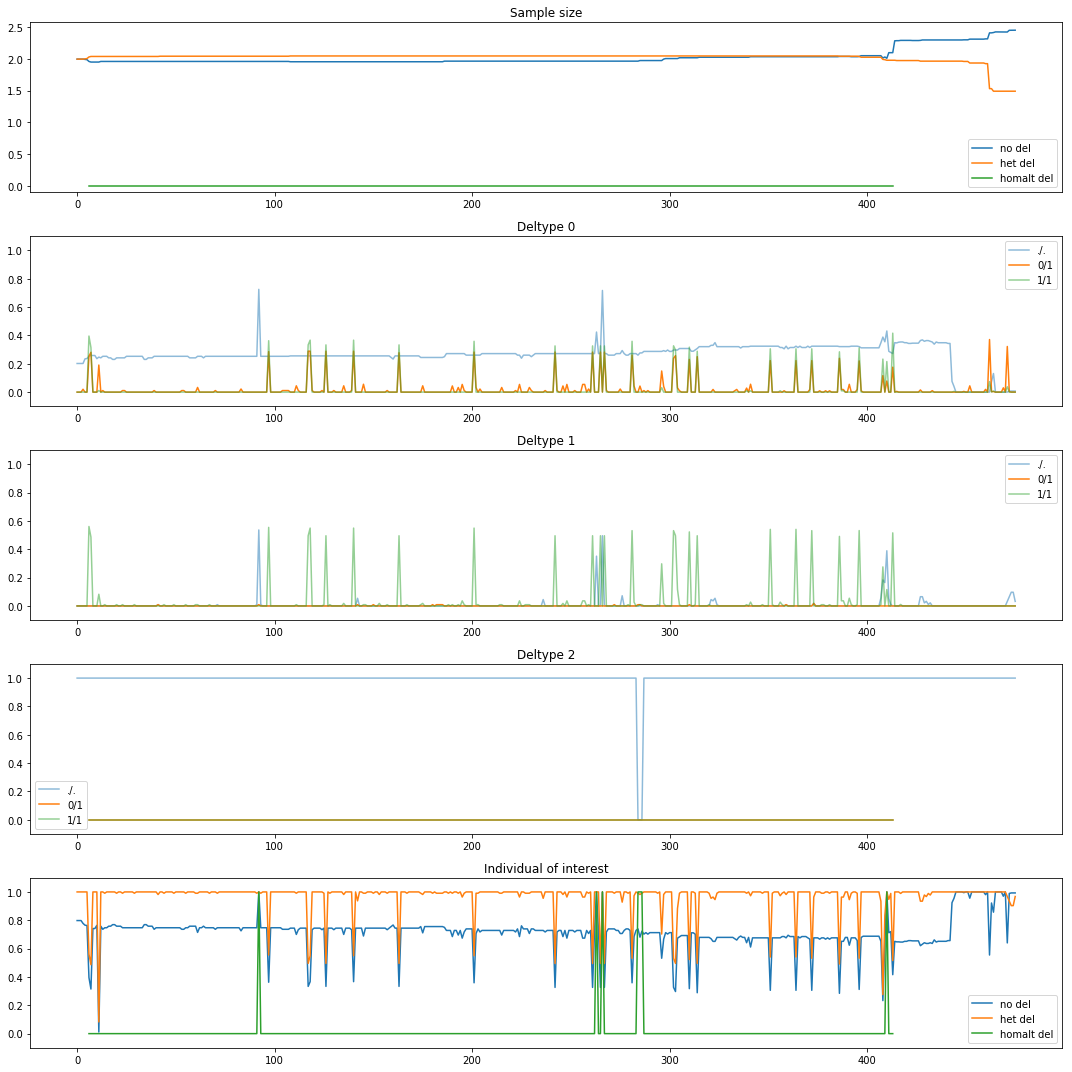

In [250]:
plt.figure(figsize=(15, 15))

plt.subplot(5, 1, 1)
plt.plot(np.log10(people_counts[indices, 0]), label='no del')
plt.plot(np.log10(people_counts[indices, 1]), label='het del')
plt.plot(np.log10(people_counts[indices, 2]), label='homalt del')
plt.title('Sample size')
plt.ylim([-0.1, None])

plt.legend()

prob_individual = np.ones((np.sum(indices), 3), dtype=float)
gen_individual = gen_segment[sample_id_to_index[region.sample_id], :]

for deltype in [0, 1, 2]:
    
    pmiss = gen_counts[indices, -1, deltype]/people_counts[indices, deltype]
    if deltype == 2:
        pmiss[people_counts[indices, deltype]==0] = 1
    
    phomref = 1 - (np.sum(gen_counts[indices, :, deltype], axis=1)/people_counts[indices, deltype])
    phet = gen_counts[indices, 1, deltype]/people_counts[indices, deltype]
    phomalt = gen_counts[indices, 2, deltype]/people_counts[indices, deltype]
    
    #prob_individual[gen_individual==-1, deltype] = pmiss[gen_individual==-1]
    prob_individual[gen_individual==0, deltype] = phomref[gen_individual==0]
    prob_individual[gen_individual==1, deltype] = phet[gen_individual==1]
    prob_individual[gen_individual==2, deltype] = phomalt[gen_individual==2]
    
    plt.subplot(5, 1, deltype+2)
    plt.plot(pmiss, label='./.', alpha=0.5)
    plt.plot(phet, label='0/1')
    plt.plot(phomalt, label='1/1', alpha=0.5)
    plt.legend()
    plt.title('Deltype %d' % deltype)
    plt.ylim([-0.1, 1.1])
    
plt.subplot(5, 1, 5)
plt.title('Individual of interest')
plt.plot(prob_individual[:, 0], label='no del')
plt.plot(prob_individual[:, 1], label='het del')
plt.plot(prob_individual[:, 2], label='homalt del')
plt.legend()
plt.ylim([-0.1, 1.1])

print(gen_individual)
print(np.sum(np.log10(prob_individual), axis=0))
        
plt.tight_layout()
plt.show()